In [140]:
## TODO 
# Find a way to filter out unwanted/invalid signals with fastaudio

In [209]:
%reset -f
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%config Completer.use_jedi = False

from fastai.vision.all import *
from fastaudio.core.all import *
from fastaudio.augment.all import *
from utils import BASE_DATAPATH, get_wingbeat_files, label_func
import psutil
from wingbeat_datasets import *
from wingbeat_models import *
torchaudio.set_audio_backend('sox_io')

In [210]:
num_epochs = 35
batch_size = 32
batch_size_val = batch_size * 2
validation_split = .2
shuffle_dataset = True
num_workers = psutil.cpu_count()
random_seed= 42
setting = 'raw'

In [246]:
z = WingbeatsDataset(dsname="Melanogaster_RL/Y", custom_label=[0], transform=transforms.Compose([FilterWingbeat(setting='bandpass'), TransformWingbeat(setting=setting)])).clean()
# sample = AudioTensor.create(z[5][2])
# norm_sample = (sample - sample.mean()) / sample.std()
# sample.show();
# # checking the mean
# print(f'Original audio mean:   {sample.mean()}')
# print(f'Normalized audio mean: {norm_sample.mean()}\n')

# # checking the standard deviation
# print(f'Original audio standard dev:   {sample.var()}')
# print(f'Normalized audio standard dev: {norm_sample.var()}')

Found 29002 in dataset: Melanogaster_RL/Y, and 1 label(s): ['Y']
Label(s) changed to [0]
Nr. of valid wingbeats: 12819


In [267]:
class AudioNormalize(Transform):
    "Normalizes a single `AudioTensor`."
    def encodes(self, x:AudioTensor): 
#         print(x.shape)
        return (x-x.mean()) / x.std()

class AudioBandPassFilter(Transform):
    "Filters a single `AudioTensor`."
    def encodes(self, x:AudioTensor): return torch.from_numpy(butter_bandpass_filter(x, lowcut=120, highcut=1500, fs=8000, order=4)).float()

    
train_dataset_list = ['Melanogaster_RL/Y', 'Suzukii_RL/Y']
test_dataset_list = ['Melanogaster_RL/Z', 'Suzukii_RL/R']
# # checking if the Transform normalized the waveform
# wav_norm = AudioNormalize()
# bpfilt = AudioBandPassFilter()
# filt_sample = bpfilt(sample)
# norm_sample = wav_norm(filt_sample)
# print(f'Audio mean after transform: {norm_sample.mean()}')
# print(f'Audio standard dev after transform: {norm_sample.var()}')

# sample.show(title='Raw')
# filt_sample.show(title='Filtered')
# norm_sample.show(title='Normalized filtered')

(AudioTensor([[-3.7231e-03,  2.0752e-03, -3.0518e-05,  ..., -4.6997e-03,
           1.0071e-03,  2.2278e-03]]),
 TensorCategory(0))

In [252]:
cfg = AudioConfig.BasicSpectrogram(n_fft=256, win_length=256, hop_length=42,to_db=True)
audio2spec = AudioToSpec.from_cfg(cfg)

dblock = DataBlock(blocks=(AudioBlock(sample_rate=8000), CategoryBlock),  
                 get_items=get_clean_wingbeatsdataset_filenames, 
                 splitter=RandomSplitter(),
                 item_tfms = [AudioBandPassFilter, AudioNormalize], #AudioNormalize],
                 batch_tfms = [audio2spec],
                 get_y=label_func2)

In [255]:
dsets = dblock.datasets(train_dataset_list)
len(dsets)

Found 29002 in dataset: Melanogaster_RL/Y, and 1 label(s): ['D. melanogaster']
No custom label applied.
Nr. of valid wingbeats: 12819
Found 25732 in dataset: Suzukii_RL/Y, and 1 label(s): ['D. suzukii']
No custom label applied.
Nr. of valid wingbeats: 17088


29907

Found 29002 in dataset: Melanogaster_RL/Y, and 1 label(s): ['D. melanogaster']
No custom label applied.
Nr. of valid wingbeats: 12819
Found 25732 in dataset: Suzukii_RL/Y, and 1 label(s): ['D. suzukii']
No custom label applied.
Nr. of valid wingbeats: 17088


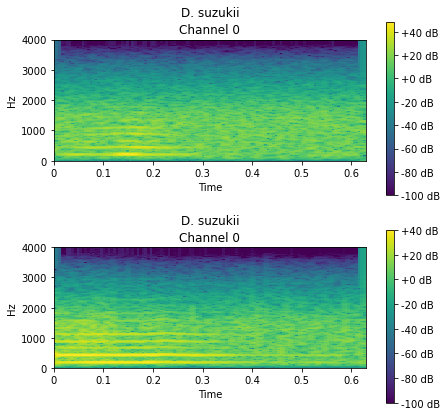

In [256]:
dbunch = dblock.dataloaders(train_dataset_list, bs=32)
dbunch.show_batch(figsize=(7,7))

In [263]:
# def get_dls(bs=64, item_tfms=[], batch_tfms=[]):
#     "Get dataloaders with given `bs` and batch/item tfms."
#     dblock = DataBlock(blocks=(AudioBlock(sample_rate=8000), CategoryBlock),  
#                      get_items=get_wingbeat_files, 
#                      splitter=RandomSplitter(),
#                      item_tfms = [AudioBandPassFilter, AudioNormalize],
#                      batch_tfms = [audio2spec],
#                      get_y=label_func)
#     dls = dblock.dataloaders("Rodrigo", bs=bs)
#     return dls


# def train_loops(dls, name, num_runs=num_runs, epochs=epochs, num_cls=50):
#     "Runs `num_runs` training loops with `dls` for given `epochs`."
#     accuracies = []
#     for i in range(num_runs):
#         # make new grayscale xresnet
#         model = xresnet18(pretrained=False, n_out=num_cls)
#         make_xresnet_grayscale(model, n_in=1)
#         # get learner for this run
#         learn = Learner(dls, model, metrics=[accuracy])
#         # train network and track accuracy
#         learn.fit_one_cycle(epochs)
#         accuracies.append(learn.recorder.values[-1][-1])
#     print(f'Average accuracy for "{name}": {sum(accuracies) / num_runs}')
    
# class StatsRecorder:
#     def __init__(self, red_dims=(0,2,3)):
#         """Accumulates normalization statistics across mini-batches.
#         ref: http://notmatthancock.github.io/2017/03/23/simple-batch-stat-updates.html
#         """
#         self.red_dims = red_dims # which mini-batch dimensions to average over
#         self.nobservations = 0   # running number of observations

#     def update(self, data):
#         """
#         data: ndarray, shape (nobservations, ndimensions)
#         """
#         # initialize stats and dimensions on first batch
#         if self.nobservations == 0:
#             self.mean = data.mean(dim=self.red_dims, keepdim=True)
#             self.std  = data.std (dim=self.red_dims,keepdim=True)
#             self.nobservations = data.shape[0]
#             self.ndimensions   = data.shape[1]
#         else:
#             if data.shape[1] != self.ndimensions:
#                 raise ValueError('Data dims do not match previous observations.')
            
#             # find mean of new mini batch
#             newmean = data.mean(dim=self.red_dims, keepdim=True)
#             newstd  = data.std(dim=self.red_dims, keepdim=True)
            
#             # update number of observations
#             m = self.nobservations * 1.0
#             n = data.shape[0]

#             # update running statistics
#             tmp = self.mean
#             self.mean = m/(m+n)*tmp + n/(m+n)*newmean
#             self.std  = m/(m+n)*self.std**2 + n/(m+n)*newstd**2 +\
#                         m*n/(m+n)**2 * (tmp - newmean)**2
#             self.std  = torch.sqrt(self.std)
                                 
#             # update total number of seen samples
#             self.nobservations += n

# def CrossValidationSplitter(col='fold', fold=1):
#     "Split `items` (supposed to be a dataframe) by fold in `col`"
#     def _inner(o):
#         assert isinstance(o, pd.DataFrame), "ColSplitter only works when your items are a pandas DataFrame"
#         col_values = o.iloc[:,col] if isinstance(col, int) else o[col]
#         valid_idx = (col_values == fold).values.astype('bool')
#         return IndexSplitter(mask2idxs(valid_idx))(o)
#     return _inner

# class SpecNormalize(Normalize):
#     "Normalize/denorm batch of `TensorImage`"
#     def encodes(self, x:TensorImageBase): return (x-self.mean) / self.std
#     def decodes(self, x:TensorImageBase):
#         f = to_cpu if x.device.type=='cpu' else noop
#         return (x*f(self.std) + f(self.mean))

# # # make global and channel normalizers
# # GlobalSpecNorm  = SpecNormalize(global_mean,  global_std,  axes=(0,2,3))
# # ChannelSpecNorm = SpecNormalize(channel_mean, channel_std, axes=(0,1,3))

# # global_stats  = StatsRecorder()
# # channel_stats = StatsRecorder(red_dims=(0,1,3))

# # # step through the training dataset
# # with torch.no_grad():
# #     for idx,(x,y) in enumerate(iter(dbunch.train)):
# #         # update normalization statistics
# #         global_stats.update(x)
# #         channel_stats.update(x)
    
# # # parse out both sets of stats
# # global_mean,global_std = global_stats.mean,global_stats.std
# # channel_mean,channel_std = channel_stats.mean,channel_stats.std

# # print(f'Shape of global mean: {global_mean.shape}')
# # print(f'Shape of global standard dev: {global_std.shape}')

# # print(f'Shape of channel mean: {channel_mean.shape}')
# # print(f'Shape of channel standard dev: {channel_std.shape}')

In [264]:
def make_xresnet_grayscale(model, n_in=1):
    "Modifies xresnet `model` for single-channel images." 
    model[0][0].in_channels = n_in
    # sum weights to reduce dimension
    model[0][0].weight = torch.nn.parameter.Parameter(model[0][0].weight.mean(1, keepdim=True))


In [271]:
dls = dbunch
name = 'No norm'
num_runs = 1
epochs = 2
num_cls=50
accuracies = []

for i in range(num_runs):
    # make new grayscale xresnet
    model = xresnet18(pretrained=False, n_out=num_cls)
    make_xresnet_grayscale(model, n_in=1)
    # get learner for this run
    learn = Learner(dls, model, metrics=[accuracy])
    # train network and track accuracy
    learn.fit_one_cycle(epochs)
    accuracies.append(learn.recorder.values[-1][-1])
print(f'Average accuracy for "{name}": {sum(accuracies) / num_runs}')
    

epoch,train_loss,valid_loss,accuracy,time
0,0.396621,0.418453,0.819428,00:48
1,0.285164,0.290315,0.873600,00:50


Average accuracy for "No norm": 0.8735997080802917


In [266]:
dblocktest = DataBlock(blocks=(AudioBlock(sample_rate=8000), CategoryBlock),  
                 get_items=get_clean_wingbeatsdataset_filenames, 
                 splitter=RandomSplitter(),
                 item_tfms = [AudioBandPassFilter, AudioNormalize], #AudioNormalize],
                 batch_tfms = [audio2spec],
                 get_y=label_func2)

In [356]:
dsets_test = dblock.datasets(test_dataset_list);
dbunch_test = dblock.dataloaders(test_dataset_list, bs=64);

Found 24763 in dataset: Melanogaster_RL/Z, and 1 label(s): ['D. melanogaster']
No custom label applied.
Nr. of valid wingbeats: 11778
Found 14348 in dataset: Suzukii_RL/R, and 1 label(s): ['D. suzukii']
No custom label applied.
Nr. of valid wingbeats: 10372
Found 24763 in dataset: Melanogaster_RL/Z, and 1 label(s): ['D. melanogaster']
No custom label applied.
Nr. of valid wingbeats: 11778
Found 14348 in dataset: Suzukii_RL/R, and 1 label(s): ['D. suzukii']
No custom label applied.
Nr. of valid wingbeats: 10372


In [392]:
y_pred = []
# learn.model.eval()
for x,y in tqdm(dsets_test):
    y_pred.append(learn.predict(x)[0]);
#     break

  0%|          | 0/22150 [00:00<?, ?it/s]

  0%|          | 0/22150 [00:00<?, ?it/s]


In [395]:
# learn.predict()

Signature: learn.predict(item, rm_type_tfms=None, with_input=False)
Docstring: Prediction on `item`, fully decoded, loss function decoded and probabilities
Source:   
    def predict(self, item, rm_type_tfms=None, with_input=False):
        dl = self.dls.test_dl([item], rm_type_tfms=rm_type_tfms, num_workers=0)
        inp,preds,_,dec_preds = self.get_preds(dl=dl, with_input=True, with_decoded=True)
        i = getattr(self.dls, 'n_inp', -1)
        inp = (inp,) if i==1 else tuplify(inp)
        dec = self.dls.decode_batch(inp + tuplify(dec_preds))[0]
        dec_inp,dec_targ = map(detuplify, [dec[:i],dec[i:]])
        res = dec_targ,dec_preds[0],preds[0]
        if with_input: res = (dec_inp,) + res
        return res
File:      ~/anaconda3/envs/fastaudio/lib/python3.7/site-packages/fastai/learner.py
Type:      method


In [416]:
learn.model.to('cpu')
next(learn.model.parameters()).is_cuda
# learn.dls.device.type = 'cpu'


False

In [425]:
import multiprocessing
cpus = multiprocessing.cpu_count()
pool = multiprocessing.Pool(processes=cpus)
from multiprocessing import set_start_method
try:
    set_start_method('spawn')
except RuntimeError:
    pass

# learn.model.eval()
def predict(x):
    learn.model.cpu()
    return learn.predict(x)[0]

In [426]:

result_list = []
result_list.append(pool.map(predict, dsets_test.items))
pool.close()
df = pd.concat(result_list[0], axis=1, sort=False)

RuntimeError: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method